The idea of this test is to check if the noise model matrix B of 4S changes if the planet is in the data. Can we compute it once for contrast curves and MCMC?

In [1]:
import sys
from copy import deepcopy
from pathlib import Path
import numpy as np
import json
from applefy.detections.contrast import Contrast
import matplotlib.pyplot as plt

from fours.utils.data_handling import load_adi_data
from fours.detection_limits.applefy_wrapper import FourSDataReduction

from applefy.utils.file_handling import open_fits
from applefy.utils.fake_planets import add_fake_planets
from applefy.utils.photometry import flux_ratio2mag, mag2flux_ratio

import torch
from fours.models.psf_subtraction import FourS

# Load the data

In [2]:
dataset_file = Path("/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5")
experiment_root_dir = Path("/fast/mbonse/s4/70_results/09_new_rotation_loss/x2_different_residual_creations/")
exp_id = str("0123a")
use_rotation_loss = True
lambda_reg = float(850)

In [3]:
science_data, angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset=str(dataset_file),
        data_tag="object_stacked_05",
        psf_template_tag="psf_template",
        para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

# other parameters
dit_psf_template = 0.0042560
dit_science = 0.08
fwhm = 3.6
pixel_scale = 0.02718

# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

In [4]:
dataset_id = "0115b"

# add the fake planet
fake_planet_config_file = "/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_" + exp_id + ".json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [5]:
data_with_fake_planet = add_fake_planets(
    input_stack=deepcopy(science_data),
    psf_template=psf_template,
    parang=angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

## Train 4S on the data without the fake planet

In [10]:
experiment_root_dir = Path("/fast/mbonse/s4/70_results/test_fast_science_intercept/")
experiment_root_dir.mkdir(exist_ok=True)

In [14]:
fours_model = FourS(
    science_cube=data_with_fake_planet,
    adi_angles=angles,
    psf_template=psf_template,
    device=0,
    work_dir=experiment_root_dir,
    verbose=True,
    rotation_grid_subsample=1,
    noise_model_lambda=10000,
    psf_fwhm=3.6,
    right_reason_mask_factor=1.5)

In [15]:
fours_model.normalization_model.mean_frame.data = torch.zeros_like(fours_model.normalization_model.mean_frame)

In [16]:
fours_model.noise_model.intercept.data = torch.ones_like(fours_model.noise_model.intercept.data)

In [ ]:
fours_model.fit_noise_model(
    num_epochs=100,
    training_name="No_mean_frame",
    fit_intercept=True,
    logging_interval=1)

S4 model: Fit noise model ... 

  0%|          | 0/100 [00:00<?, ?it/s]

## remplace the mean frame

In [27]:
_, residual_sequence = fours_model._get_residual_sequence()

In [32]:
residual_sequence_mean_sub = residual_sequence - torch.mean(residual_sequence, axis=0)

In [33]:
rotated_residual_sequence = fours_model.rotation_model(
            residual_sequence_mean_sub,
            parang_idx=torch.arange(len(residual_sequence)))

In [34]:
mean_residual = torch.mean(rotated_residual_sequence, axis=0)[0]

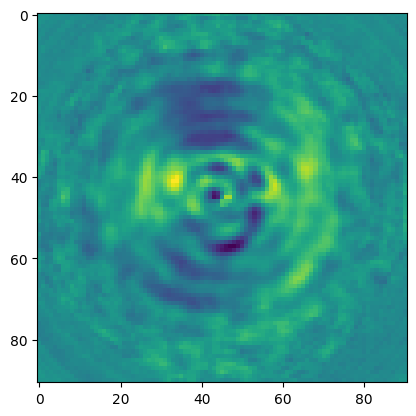

In [35]:
plt.imshow(mean_residual.detach().numpy())